
# Integrantes:
-Rodrigo Pino

-Cristobal Cortes

-Edgar Ramos

-Christian Garrido


Repositorio: https://github.com/cgarrido2001/PneumoniaMNIST.git

# Acerca de la data

#### El conjunto de datos original consiste en imágenes de rayos X de radiografías de tórax recopiladas de pacientes pediátricos de uno a cinco años del Guangzhou Women and Children's Medical Center en Guangzhou. Inicialmente, el conjunto de datos se divide en dos conjuntos: entrenamiento (train) y prueba (test).

#### Sin embargo, como parte de este proyecto, se realizará una subdivisión adicional del conjunto de entrenamiento para crear un conjunto de validación. Algunos datos del conjunto de entrenamiento se seleccionarán aleatoriamente y se utilizarán como datos de validación para evaluar el rendimiento del modelo durante el entrenamiento.

#### En resumen, el conjunto de datos original comprende imágenes de rayos X de tórax de pacientes pediátricos, divididas en conjuntos de entrenamiento y prueba. Además, como parte del proceso de este proyecto, se creará un conjunto de validación mediante la selección aleatoria de datos del conjunto de entrenamiento.



# Reconocimientos

#### Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

#### License: CC BY 4.0

#### Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Concatenate
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns

In [74]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../../chest_xray/train/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10,
    validation_split=0.2,
    subset="training"
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../../chest_xray/train/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10,
    validation_split=0.2,
    subset="validation"
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../../chest_xray/test/',
    labels="inferred",
    label_mode="binary",
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=True,
    seed=10
)


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [24]:
# Función para mostrar imágenes
def show_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if (labels[i] == 0):
              plt.title("NORMAL")
            else:
              plt.title("PNEUMONIA")
            plt.axis("off")
    plt.show()

2023-07-02 22:00:08.141195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]
2023-07-02 22:00:08.141552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4186]
	 [[{{node Placeholder/_4}}]]


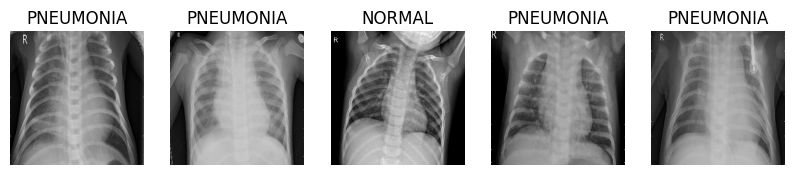

In [25]:
show_images(train_dataset)

2023-07-02 22:03:34.831954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1046]
	 [[{{node Placeholder/_4}}]]
2023-07-02 22:03:34.832571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1046]
	 [[{{node Placeholder/_4}}]]


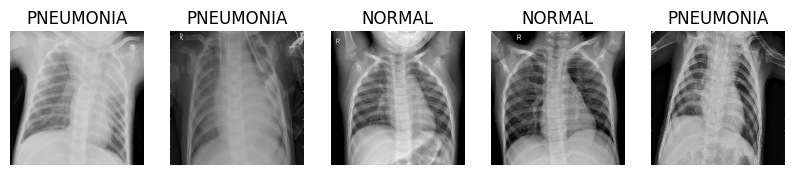

In [27]:
show_images(valid_dataset)

2023-07-02 22:03:48.102640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]
2023-07-02 22:03:48.102919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]


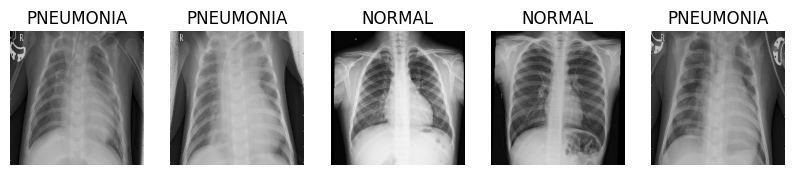

In [28]:
show_images(test_dataset)

# Ensemble models

construir un clasificador basado en la concatenacion de dos modelos, VGG16 y ResNet50 con los pesos pre-entrenados en imagenet

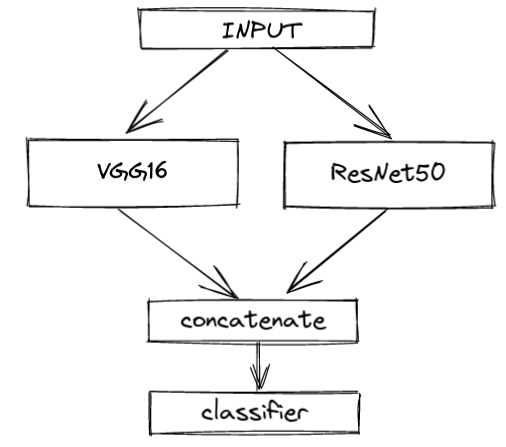

In [64]:
base_model_VGG16 = VGG16(weights="imagenet",
                         include_top=False,
                         input_shape=(224,224,3)
                         )
#Congelar pesos
base_model_VGG16.trainable = False

base_model_Resnet50 = ResNet50(weights="imagenet",
                         include_top=False,
                         input_shape=(224,224,3)
                         )
#Congelar pesos
base_model_Resnet50.trainable = False

# Construir modelo

In [65]:
from tensorflow.keras.utils import plot_model

#Obtener Featuremaps de ambos modelos

output_vgg16 = base_model_VGG16.output
output_resnet50 = base_model_Resnet50.output

print(output_vgg16.shape, output_resnet50.shape)

(None, 7, 7, 512) (None, 7, 7, 2048)


In [66]:
input = tf.keras.layers.Input(shape=(224, 224, 3))

x1 = base_model_VGG16(input)
x2 = base_model_Resnet50(input)

x = Concatenate()([x1, x2])
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

modelo2 = tf.keras.models.Model(inputs=input, outputs=x)

In [73]:
modelo2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 7, 7, 2560)   0           ['vgg16[0][0]',              

# Compilar y Establecer directorio para guardar registros del modelo

In [ ]:
modelo2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["Accuracy", tf.keras.metrics.Recall()])

tb = TensorBoard(log_dir="./logs/modelo2")

# Entrenar modelo

In [ ]:
modelo2.fit(train_dataset, validation_data=(valid_dataset), epochs=20, callbacks=[tb])

# Guardar modelo

In [ ]:
modelo2.save("./saved_models")

# Cargar modelo

In [30]:
modelo2 = load_model("./Saved_models/")

# Ver Tensorboard

In [63]:
tb = TensorBoard(log_dir="./logs")
!tensorboard --logdir=./logs

2023-07-03 22:23:08.058541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-03 22:23:09.657217: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Colores modelos

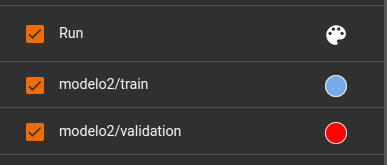

### Grafico Accuracy vs Epochs

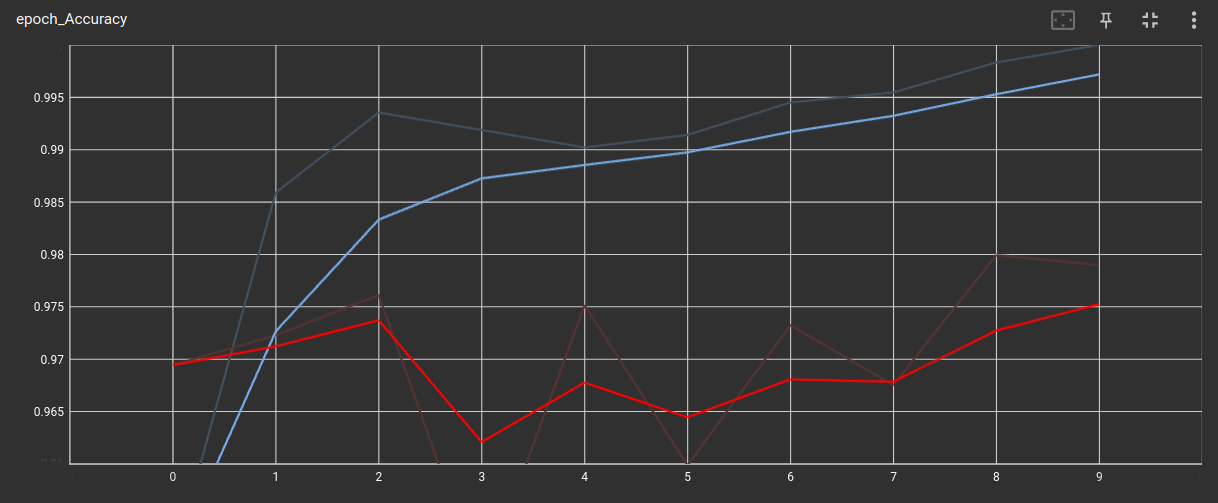

### En el grafico de Accuracy vs epochs se puede ver que ambos graficos tienen un Accuracy por sobre el 95% en todo momento, lo que nos indica que el modelo es bastante bueno. Sin embargo, para determinar si un modelo es bueno o malo no basta con observar solo el Accuracy, se deben observar otras metricas y ademas va a depender del contexto.

### Grafico loss vs epochs

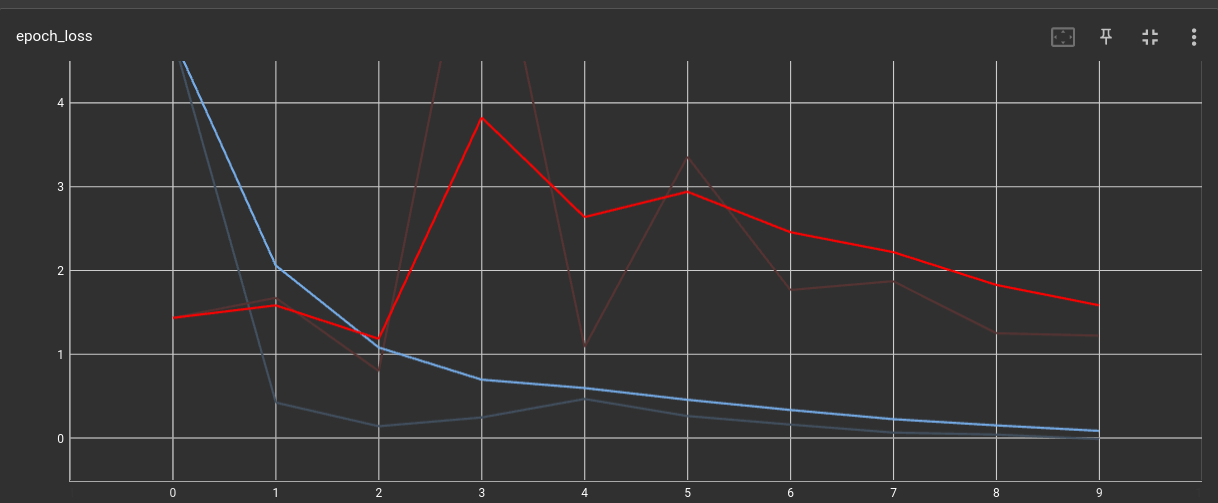

### Se puede ver gracias al grafico de perdida que el modelo no se esta sobreajustando al set de entrenamiento, esto se puede ver reflejado ya que al aumentar las epocas ambas curvas van disminuyendo, significa que el modelo si esta logrando generalizar caracteristicas de los datos para nuevos conjuntos de imagenes y logra tener un buen rendimiento. El modelo se estaria sobreajustando si la curva roja la cual son las predicciones en el set de validacion fuese aumentando a medida que las epocas aumentan, mientras que las curva azul siguiese disminuyendo, En ese caso significaria que el modelo se este aprendiendo el conjunto de entrenamiento y tenga un pesimo rendimiento para cualquier otro conjunto de imagenes, lo cual es lo que se busca evitar.

### Grafico recall vs epochs

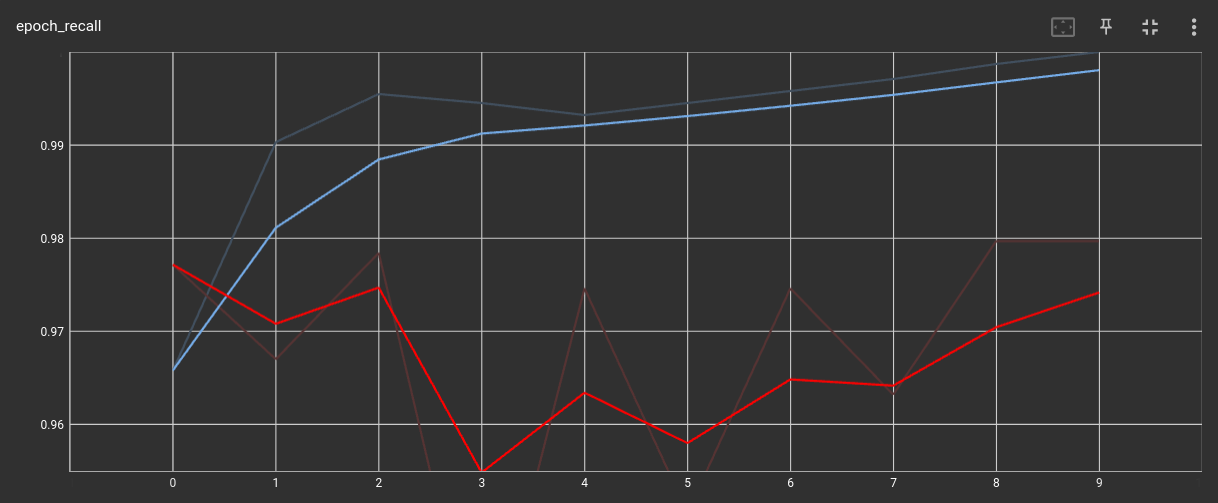

### El recall es una metrica que evalua la capacidad del modelo para identificar correctamente las muestras positivas de una clase determinada, en este caso la presencia de neumonia. Este grafico nos muestera como el recall del modelo evoluciona a medida que el modelo se entrena durante las distintas epocas. Este grafico se analiza con el proposito de visualizar si el modelo esta mejorando su capacidad de detectar correctamente las muestras positivas a medida que se realiza el entrenamiento. Un aumento progresivo y constante en el recall a lo largo de las epocas podria indicar un mejor rendimiento del modelo como se ve en este caso.

# Metricas

### 1) Obtener etiquetas del set de validación

### 2) Obtener etiquetas predichas por el modelo

########################################################################################################


# 1)

In [50]:
true_valid_labels = []
for _, labels in valid_dataset:
    true_valid_labels.extend(labels.numpy())
true_valid_labels = np.array(true_valid_labels)

########################################################################################################################################

# 2)

In [51]:
predicted_labels = modelo2.predict(valid_dataset)

33/33 [==============================] - 223s 7s/step


# Aproximar valores a 0 o 1

In [56]:
umbral = 0.5
predicted_labels_aprox = np.where(predicted_labels > umbral, 1, 0)

# Matriz de confusion

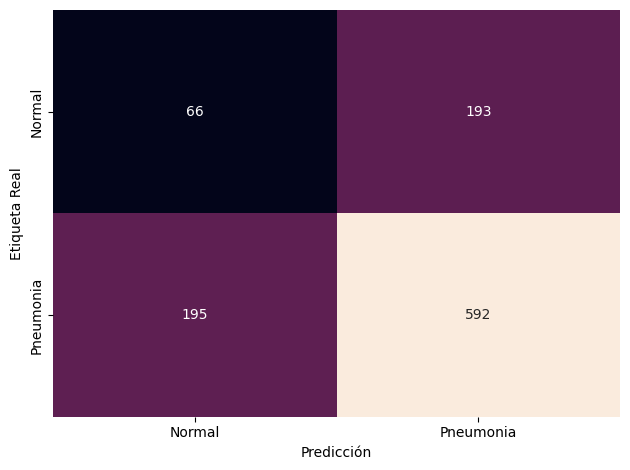

In [61]:
# Matriz de confusión para VGG16_freezed
mc_modelo2 = confusion_matrix(true_valid_labels, predicted_labels_aprox)

# Definir etiquetas de las clases
etiquetas_clases = ['Normal', 'Pneumonia']

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear matriz de colores
sns.heatmap(mc_modelo2, annot=True, fmt='d', cbar=False, ax=ax)

# Configurar etiquetas de los ejes
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta Real')
ax.set_xticklabels(etiquetas_clases)
ax.set_yticklabels(etiquetas_clases)

# Ajustar espaciado
plt.tight_layout()

# Mostrar gráfico de la matriz de confusión
plt.show()

# Reporte de resultados obtenidos

In [62]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Pneumonia']

print("\nReporte de Clasificación: Modelo2")
print(classification_report(true_valid_labels, predicted_labels_aprox, target_names=target_names))


Reporte de Clasificación: Modelo2
              precision    recall  f1-score   support

      Normal       0.25      0.25      0.25       259
   Pneumonia       0.75      0.75      0.75       787

    accuracy                           0.63      1046
   macro avg       0.50      0.50      0.50      1046
weighted avg       0.63      0.63      0.63      1046



### A continuación, se explica el significado de las métricas del Reporte:

* Precision: Indica la precisión de las predicciones del modelo para cada clase. En este caso, para la clase "Normal" se obtiene una precisión de 0.25, lo que significa que de todas las muestras clasificadas como "Normal" por el modelo, solo el 25% son realmente "Normal". Para la clase "Pneumonia", se obtiene una precisión de 0.75, lo que significa que el 75% de las muestras clasificadas como "Pneumonia" por el modelo son realmente "Pneumonia".

* Recall: Representa la proporción de muestras positivas que fueron correctamente identificadas por el modelo. En este caso, tanto para la clase "Normal" como para la clase "Pneumonia", se obtiene un recall de 0.25 y 0.75, respectivamente. Esto indica que el modelo identifica correctamente el 25% de las muestras "Normal" y el 75% de las muestras "Pneumonia".

* F1-score: Es una medida que combina la precisión y el recall, proporcionando un valor de rendimiento general para cada clase. El F1-score se calcula como la media armónica de la precisión y el recall. Para la clase "Normal", se obtiene un F1-score de 0.25, y para la clase "Pneumonia", se obtiene un F1-score de 0.75.

* Support: segun la documentacion de sklearn, indica el número de predicciones en cada clase.

* Accuracy: Representa la precisión global del modelo, es decir, la proporción de muestras correctamente clasificadas en relación con el total de muestras. En este caso, se obtiene una precisión global del 63%.

* Macro avg: Es el promedio no ponderado de las métricas para todas las clases. En este caso, el promedio de las precisiones, recalls y F1-scores es de 0.50.

* Weighted avg: Es el promedio ponderado de las métricas para todas las clases, donde el peso se calcula en función del número de muestras en cada clase. En este caso, el promedio ponderado de las precisiones, recalls y F1-scores es de 0.63.

# Sintesis


Para sintetisar, el modelo Modelo2 muestra un rendimiento modesto con una precisión y recall relativamente bajos para la clase "Normal", mientras que muestra una precisión y recall más altos para la clase "Pneumonia", lo cual es lo que se busca debido a que es mas conveniente detectar si una persona tenga esta enfermedad a que no la padezca, esto con el fin de que pueda realizarse tratamientos para prevenir esta enfermedad o tratarla.

# Conclusiones

Los resultados obtenidos muestran un rendimiento modesto del modelo2 en la deteccion de neumonia. La matriz de confusion revela que el modelo logra clasificar correctamente 66 muestras como "Normal" y 592 muestras como "Pneumonia". Sin embargo, se observa una alta cantidad de falsos positivos, para ser exactos 193 y una alta cantidad de falsos negativos(195).

El informe de clasificacion respalda estos hallazgos, donde se tiene una presicion del 25% y un recall del 25% para la clase "Normal", mientras que para la clase "Pneumonia" se obtiene una precision del 75% y un recall del 75%. Esto indica que el modelo tiene problemas para distinguir entre muestras "Normal" y  "Pneumonia", con una tendencia a clasificar mas muestras como "Pneumonia".

En la sintesis mencionada anteriormente se menciona que es mas conveniente detectar si una persona tiene neumonia que determinar si no la padece. Esta afirmacion puede ser valida desde el punto de vista medico, ya que la deteccion temprana de neumonia es crucial para el tratamiento adecuado. Sin embargo, en terminos del rendimiento del modelo, es deseable lograr un equilibrio entre la precision y el recall para ambas clases, con el objetivo de minimizar tanto los falsos positivos como los falsos negativos.

Para concluir, el modelo2 muestra un rendimiento modesto en la deteccion de neumonia, pero requiere mejoras para reducir los errores de clasificacion. Se podrian explorar diferentes enfoques, como ajustar la arquitectura del modelo, modificar hiperparametros para mejorar el rendimiento del modelo y capacidad de discriminacion entre las clases.